In [1]:
import os
import math
import torch
import wandb
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.utilities.model_summary import ModelSummary
from torchvision import transforms

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from data.cats_and_dogs import BinaryCIFARDataModule
from models.model_cnn_mika import CatsDogsModel

### Loading Configuration

In the following steps, we will load the configuration settings using the `load_configuration` function. The configuration is stored in the `config` variable which will be used throughout the script.

In [2]:
from config.load_configuration import load_configuration
config = load_configuration()

PC Name: DESKTOP-MIKA
Loaded configuration from config/config_mika.yaml


### Setting Seeds for Reproducibility

To ensure comparable and reproducible results, we set the random seed using the `seed_everything` function from PyTorch Lightning. This helps in achieving consistent behavior across multiple runs of the notebook.

In [3]:
pl.seed_everything(config['seed'])
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"   # disable oneDNN optimizations for reproducibility

Seed set to 42


### Checking for GPU Devices

In this step, we check for the availability of GPU devices and print the device currently being used by PyTorch. This ensures that the computations are performed on the most efficient hardware available.

In [4]:
# Check if CUDA is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Torch Version: ', torch.__version__)
print('Using device: ', device)
if device.type == 'cuda':
    print('Cuda Version: ', torch.version.cuda)
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    torch.set_float32_matmul_precision('high')

Torch Version:  2.7.0+cu128
Using device:  cuda
Cuda Version:  12.8
NVIDIA GeForce GTX 1060 6GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### Defining Transformations and Instantiating DataModule

In this step, we will define the necessary data transformations and initialize the `Animal_DataModule` with the provided configuration.

In [5]:
# TODO: Define transformations here

transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to match CIFAR10 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard ImageNet normalization
])

dm = BinaryCIFARDataModule(transform=transform, batch_size=config['batch_size'], num_workers=2, persistent_workers=True)
dm.setup()
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()

print('Train dataset size:', len(dm.train_dataset))
print('Validation dataset size:', len(dm.val_dataset))
print('Test dataset size:', len(dm.test_dataset))

# sample_img, sample_label = dm.train_dataset[0]
# print("Sample image shape:", sample_img.shape)
# print("Sample label:", sample_label)

Train dataset size: 8000
Validation dataset size: 2000
Test dataset size: 2000


### Creating the Model

In this step, we will define the model architecture and print its summary using the `ModelSummary` utility from PyTorch Lightning. This provides an overview of the model's layers, parameters, and structure.

In [6]:
model = CatsDogsModel()
print(ModelSummary(model, max_depth=-1))  

   | Name           | Type              | Params | Mode 
--------------------------------------------------------------
0  | criterion      | BCEWithLogitsLoss | 0      | train
1  | sigmoid        | Sigmoid           | 0      | train
2  | model          | Sequential        | 1.1 M  | train
3  | model.0        | Conv2d            | 896    | train
4  | model.1        | BatchNorm2d       | 64     | train
5  | model.2        | ReLU              | 0      | train
6  | model.3        | MaxPool2d         | 0      | train
7  | model.4        | Conv2d            | 18.5 K | train
8  | model.5        | BatchNorm2d       | 128    | train
9  | model.6        | ReLU              | 0      | train
10 | model.7        | MaxPool2d         | 0      | train
11 | model.8        | Conv2d            | 73.9 K | train
12 | model.9        | BatchNorm2d       | 256    | train
13 | model.10       | ReLU              | 0      | train
14 | model.11       | MaxPool2d         | 0      | train
15 | model.12       | Fla

In [7]:
# Initialize the Wandb logger
wandb.login()
wandb_logger = WandbLogger(
    project=config['wandb_project_name'],
    name=config['wandb_experiment_name'],
    config={
        'dataset': 'CIFAR-binary',
        'batch_size': config['batch_size'],
        'max_epochs': config['max_epochs'],
        'learning_rate': config['learning_rate']
    }
)

wandb: Currently logged in as: erzlektor (VDKI-Hasen) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [8]:
# Initialize Trainer with wandb logger, using early stopping callback (https://lightning.ai/docs/pytorch/stable/common/early_stopping.html)
trainer = Trainer(
    max_epochs=config['max_epochs'], 
    default_root_dir='model/checkpoint/', #data_directory, 
    accelerator="auto", 
    devices="auto", 
    strategy="auto",
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, mode='min')], 
    logger=wandb_logger)

# Training of the model
trainer.fit(model=model, datamodule=dm)

# Finish wandb
wandb.finish()

# Create a filename with date identifier
date_str = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"catsdogs_model_{date_str}.ckpt"

# Save the model's state_dict to the path specified in config
save_path = os.path.join(os.path.dirname(config['path_to_models']), model_filename)
trainer.save_checkpoint(save_path)
print(f"Model checkpoint saved as {save_path}")
config['path_to_model'] = save_path


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | criterion      | BCEWithLogitsLoss | 0      | train
1 | sigmoid        | Sigmoid           | 0      | train
2 | model          | Sequential        | 1.1 M  | train
3 | train_accuracy | BinaryAccuracy    | 0      | train
4 | val_accuracy   | BinaryAccuracy    | 0      | train
5 | val_precision  | BinaryPrecision   | 0      | train
6 | val_recall     | BinaryRecall      | 0      | train
7 | test_accuracy  | BinaryAccuracy    | 0      | train
-------------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.573     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 250/250 [00:06<00:00, 35.91it/s, v_num=ref0, val_loss=0.694, val_acc=0.771]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 250/250 [00:07<00:00, 35.43it/s, v_num=ref0, val_loss=0.694, val_acc=0.771]


epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇████
train_acc,▁▃▄▅▅▆▇▇██
train_loss,▆▇▇▇▅▆▆▅▇▆█▅▆▆▅▄▄▃▅▆▄▄▇▄▄▄▅▃▄▃▄▅▄▁▃▆▂▁▃▂
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
val_acc,▁▄▄▆██▅█▅▆
val_loss,▅▃▃▂▁▁▄▁▇█
epoch,9
train_acc,0.89875
train_loss,0.21379
trainer/global_step,2499
val_acc,0.7715


Model checkpoint saved as D:/HKA_IMS_Drive/SS25_MSYS_KAER-AI-PoseAct/21_Test_Data/Models/CNN\catsdogs_model_20250519_220440.ckpt


# Predict with the Model


In [9]:
# from PIL import Image
# import torch
# # Load the saved model weights from the path specified in config

# def predict_image(path, model):
#     transform = transforms.Compose([
#         transforms.Resize((150, 150)),
#         transforms.ToTensor(),
#         transforms.Normalize([0.5]*3, [0.5]*3)
#     ])

#     img = Image.open(path).convert('RGB')
#     img = transform(img).unsqueeze(0)  # Add batch dimension

#     model.eval()
#     with torch.no_grad():
#         pred = model(img)
#         result = "Dog" if pred.item() > 0.5 else "Cat"
#     print(f"Prediction: {result}")


# Create and visualize metrics for test data set

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
f:\Users\Mika\Anaconda\envs\VDKI-Projekt\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loaded model weights from D:/HKA_IMS_Drive/SS25_MSYS_KAER-AI-PoseAct/21_Test_Data/Models/CNN\catsdogs_model_20250519_220440.ckpt
Testing DataLoader 0: 100%|██████████| 63/63 [00:01<00:00, 60.42it/s]Predictions shape


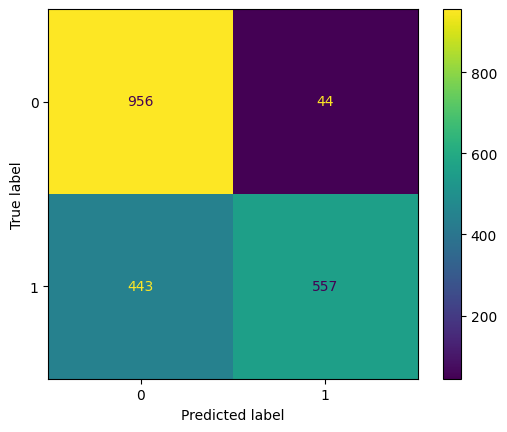

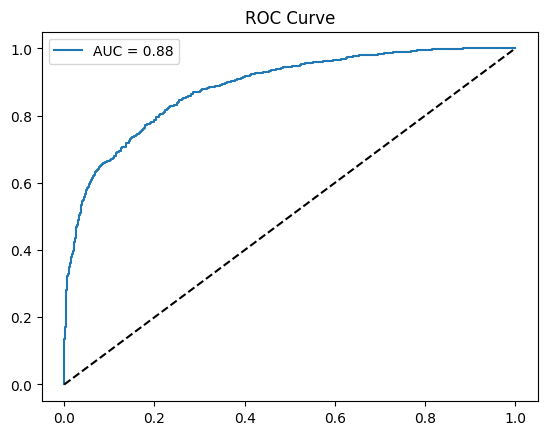

Testing DataLoader 0: 100%|██████████| 63/63 [00:01<00:00, 42.21it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7565000057220459
        test_loss           0.7806994915008545
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.7806994915008545, 'test_acc': 0.7565000057220459}]

In [10]:
model_path = config['path_to_model']
if model_path and os.path.exists(model_path):
    model = CatsDogsModel.load_from_checkpoint(model_path, map_location=device)
    print(f"Loaded model weights from {model_path}")
else:
    print("Model path not found or not specified in config.")

# Ensure model is in eval mode and on the correct device
# model = model.to(device)
model.eval()

# all_labels = []
# all_preds = []
# all_probs = []

# with torch.no_grad():
#     for images, labels in test_loader:
#         images = images.to(device)
#         labels = labels.to(device)
#         outputs = model(images)
#         probs = outputs.squeeze().cpu().numpy()
#         preds = (probs > 0.5).astype(int)
#         all_labels.extend(labels.cpu().numpy())
#         all_preds.extend(preds)
#         all_probs.extend(probs)

trainer = Trainer()
trainer.test(model=model, dataloaders=test_loader)

# all_labels = np.array(all_labels)
# all_preds = np.array(all_preds)
# all_probs = np.array(all_probs)

# # Confusion Matrix
# cm = confusion_matrix(all_labels, all_preds)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cat", "Dog"])
# disp.plot(cmap=plt.cm.Blues)
# plt.title("Confusion Matrix")
# plt.show()

# # ROC Curve
# fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
# roc_auc = auc(fpr, tpr)

# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()